gen|  eval  |    f_opt    |    f_max    |    f_avg    |    f_min    |    f_std    
----------------------------------------------------------------------------------
 0 |   30   | 4.57047E+02 | 4.57164E+02 | 4.57115E+02 | 4.57047E+02 | 3.56346E-02 
 1 |   60   | 4.57047E+02 | 4.57156E+02 | 4.57096E+02 | 4.57047E+02 | 3.08637E-02 
 2 |   90   | 4.57039E+02 | 4.57147E+02 | 4.57081E+02 | 4.57039E+02 | 3.03807E-02 
 3 |  120   | 4.57038E+02 | 4.57145E+02 | 4.57067E+02 | 4.57038E+02 | 2.52292E-02 
 4 |  150   | 4.57038E+02 | 4.57098E+02 | 4.57056E+02 | 4.57038E+02 | 1.86095E-02 
 5 |  180   | 4.57038E+02 | 4.57090E+02 | 4.57050E+02 | 4.57038E+02 | 1.45057E-02 
 6 |  210   | 4.57038E+02 | 4.57071E+02 | 4.57043E+02 | 4.57038E+02 | 7.56435E-03 
 7 |  240   | 4.57038E+02 | 4.57071E+02 | 4.57041E+02 | 4.57038E+02 | 6.71202E-03 
 8 |  270   | 4.57038E+02 | 4.57050E+02 | 4.57039E+02 | 4.57038E+02 | 2.53834E-03 
 9 |  300   | 4.57038E+02 | 4.57042E+02 | 4.57038E+02 | 4.57038E+02 | 8.08244E-04 
 10|

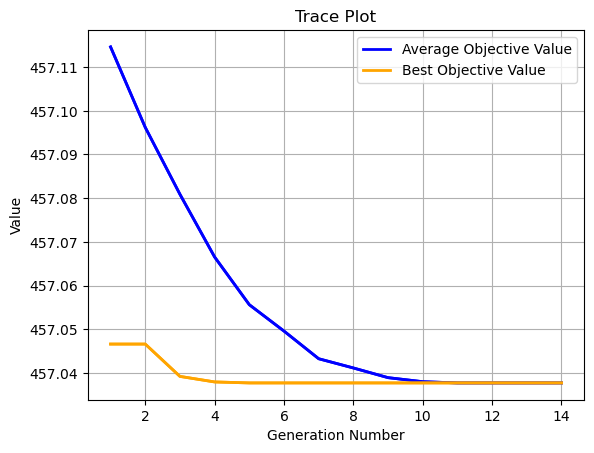

Execution time: 2.955026865005493 s
Evaluation number: 420
The best objective value is: 457.0377000337382
The best variables are: 
0.01	0.01	
最优结果：k1 = 0.010000, k2 = 0.010000


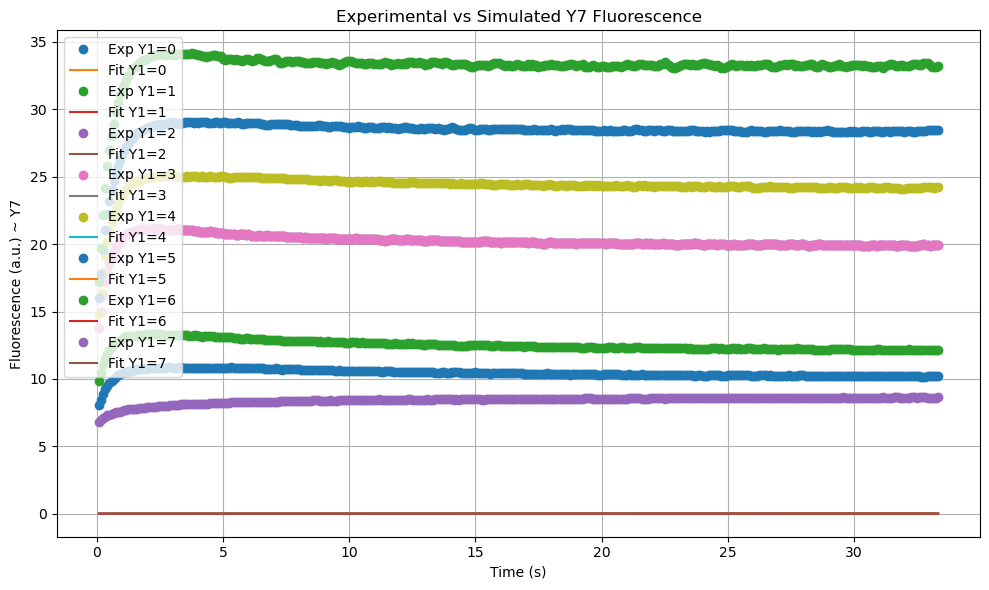

In [8]:
import numpy as np
import pandas as pd
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import geatpy as ea

# ======================== 1. 读取实验数据 ========================
data = pd.read_excel(r'C:\Users\86158\Desktop\2.xlsx')  # 确保是你最新上传的那份数据
time = data.iloc[:, 0].dropna().values
y_exp_matrix = data.iloc[:, 1:].values

# y_exp_matrix：每列是不同初始Y1下的荧光强度（代表Y7）
y1_initial_values = list(range(8))  # Y1 从 0 到 7

# ======================== 2. 定义微分方程组 ========================
def reaction_system(y, t, k1, k2):
    y1, y2, y3, y4, y5, y6, y7, y8 = y

    r1 = k1 * y1 * y2 * y3
    r2 = k2 * y4 * y5

    dy1 = -r1
    dy2 = -r1
    dy3 = -r1
    dy4 = r1 - r2
    dy5 = r1 - r2
    dy6 = r2
    dy7 = r2
    dy8 = r2

    return [dy1, dy2, dy3, dy4, dy5, dy6, dy7, dy8]

# ======================== 3. 定义优化目标函数 ========================
@ea.Problem.single
def evalVars(Vars):
    k1, k2 = Vars
    total_loss = 0
    for idx, y1_init in enumerate(y1_initial_values):
        y0 = [y1_init, 50.0, 0.16, 0.0, 0.0, 50.0, 0.0, 0.0]
        try:
            sol = odeint(reaction_system, y0, time, args=(k1, k2))
            y7_sim = sol[:, 6]
            y7_exp = y_exp_matrix[:, idx]
            loss = np.mean((y7_sim - y7_exp) ** 2)
            total_loss += loss
        except Exception:
            return 1e6  # 若模拟失败，惩罚
    return total_loss / len(y1_initial_values)

# ======================== 4. 定义优化问题 ========================
problem = ea.Problem(
    name='fit_k1_k2',
    M=1,
    maxormins=[1],  # 最小化
    Dim=2,
    varTypes=[0, 0],  # 连续变量
    lb=[1e-6, 1e-6],  # 下界
    ub=[0.01, 0.01],  # 上界
    evalVars=evalVars
)

# ======================== 5. 定义算法参数 ========================
algorithm = ea.soea_DE_rand_1_bin_templet(
    problem,
    ea.Population(Encoding='RI', NIND=30),
    MAXGEN=50,
    logTras=1,
    trappedValue=1e-6,
    maxTrappedCount=10
)

# ======================== 6. 启动优化 ========================
res = ea.optimize(
    algorithm,
    seed=1,
    verbose=True,
    drawing=1,
    outputMsg=True,
    drawLog=False,
    saveFlag=False
)

# ======================== 7. 结果可视化 ========================
k1_opt, k2_opt = res['Vars'].flatten()
print(f"最优结果：k1 = {k1_opt:.6f}, k2 = {k2_opt:.6f}")

plt.figure(figsize=(10, 6))
for idx, y1_init in enumerate(y1_initial_values):
    y0 = [y1_init, 50.0, 0.16, 0.0, 0.0, 50.0, 0.0, 0.0]
    sol = odeint(reaction_system, y0, time, args=(k1_opt, k2_opt))
    plt.plot(time, y_exp_matrix[:, idx], 'o', label=f'Exp Y1={y1_init}')
    plt.plot(time, sol[:, 6], '-', label=f'Fit Y1={y1_init}')
plt.xlabel("Time (s)")
plt.ylabel("Fluorescence (a.u.) ~ Y7")
plt.title("Experimental vs Simulated Y7 Fluorescence")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



In [ ]:
import